In [1]:
from netCDF4 import Dataset
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
from wrf import get_cartopy, getvar, latlon_coords, to_np, extract_times, ALL_TIMES

Z0_VALUES = [0.5, 2, 5, 10]
# AHE_VALUES = [50, 100, 200]
AHE_VALUES = [0, 0, 10, 50, 100, 500]
threshold_datetime = np.datetime64('2025-03-10')

In [2]:
template_dataset = Dataset(glob(f'/home/guc/runs/*ahe-100-z0-10/wrfout*')[0])
template_var = getvar(template_dataset, "T2", timeidx=0)
times = extract_times(template_dataset, timeidx=ALL_TIMES)
times = times[times >= threshold_datetime]

In [3]:
results = {}

for ahe in AHE_VALUES:
    # file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-{ahe}-rnd-wind/wrfout*')[0]
    file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-{ahe}-z0-1/wrfout*.backup')[0]
    dataset = Dataset(file_name)

    var_means = np.array([])

    for time_idx, date_time in enumerate(times):
        print(f'Processing AHE={ahe}, {date_time}', end='\r')
        var_data = getvar(dataset, "T2", timeidx=time_idx)

        if date_time == threshold_datetime:
            var_means = np.abs(to_np(var_data))
            template_var = var_data
        else:
            var_means += np.abs(to_np(var_data))

    results[ahe] = var_means

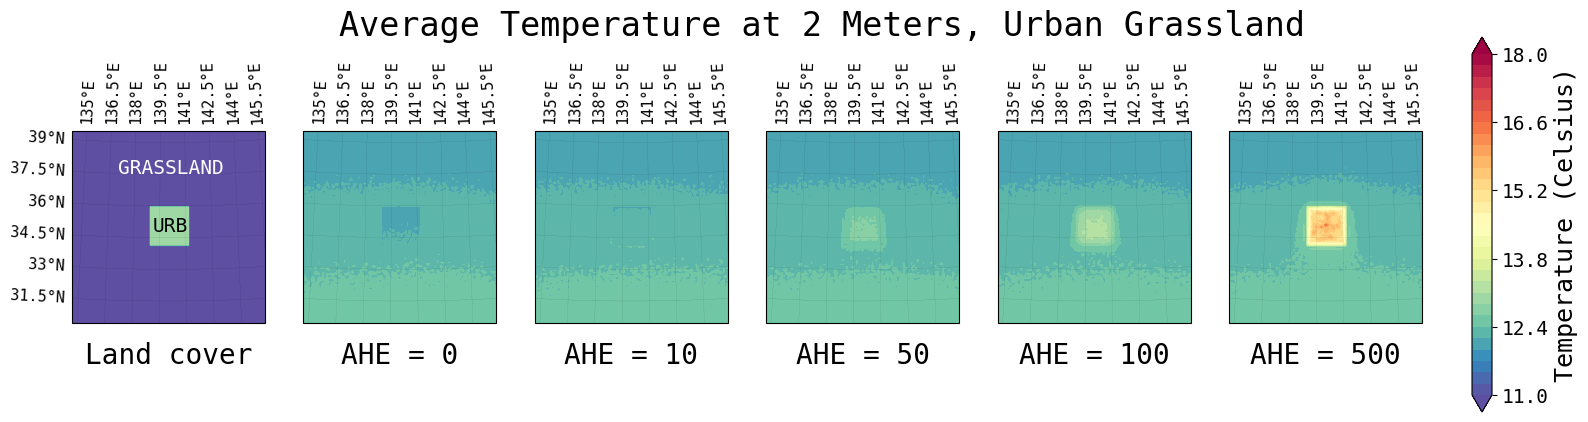

In [16]:
plt.rcParams["font.family"] = "DejaVu Sans Mono"
plt.rcParams["font.size"] = 11

# plot_lim = np.linspace(0, 2000, 51)
plot_lim = np.linspace(11, 18, 31)
# plot_lim = np.linspace(0, 2, 21)

z_data = getvar(template_dataset, "z", timeidx=0)
lats, lons = latlon_coords(z_data)
cart_proj = get_cartopy(z_data)

column_size = 6

fig, axes = plt.subplots(1, column_size, figsize=(20, 5), subplot_kw={'projection': cart_proj})
# fig, axes = plt.subplots(1, column_size, figsize=(20, 4))

for idx, ahe in enumerate(AHE_VALUES):
# for idx, z0 in enumerate(Z0_VALUES):
    i, j = idx // column_size, idx % column_size

    var = results[ahe]
    gridlines = axes[j].gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        x_inline=False,
        y_inline=False,
        linewidth=0.1,
        color="black",
        linestyle="dotted"
    )
    gridlines.bottom_labels = None
    gridlines.right_labels = None

    if j != 0:
        gridlines.left_labels = None

        contour = axes[j].contourf(
            to_np(lons),
            to_np(lats),
            (var / len(times)) - 273.15,
            plot_lim,
            cmap="Spectral_r",
            extend='both',
            transform=crs.PlateCarree()
        )

        # axes[j].set_title(f'Z0 = {z0}', y=-0.15)
        axes[j].set_title(f'AHE = {ahe}', y=-0.25, fontsize=20)

    if i == 0 and j == column_size - 1:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes((0.825, 0.125, 0.01, 0.75))
        cbar = fig.colorbar(contour, cax=cbar_ax, ticks=plot_lim[::6])
        cbar.ax.tick_params(labelsize=14)
        # cbar.ax.set_ylabel('Height (m)')
        cbar.ax.set_ylabel('Temperature (Celsius)', fontsize=18)
        # cbar.ax.set_ylabel('Wind Speed (m/s)')

axes[0].contourf(
    to_np(lons),
    to_np(lats),
    template_dataset.variables['LU_INDEX'][0],
    plot_lim,
    cmap="Spectral_r",
    extend='both',
    transform=crs.PlateCarree()
)
axes[0].set_title(f'Land cover', y=-0.25, fontsize=20)
axes[0].text(139.1, 34.8, 'URB', transform=crs.PlateCarree(), fontsize=14)
axes[0].text(137, 37.5, 'GRASSLAND', transform=crs.PlateCarree(), color='white', fontsize=14)

# fig.suptitle(f"Average U-direction Wind Speed at 10 Meters, Real Model, Urban Grassland, AHE = 100")
fig.suptitle(f"Average Temperature at 2 Meters, Urban Grassland", fontsize=24, y=0.93)
plt.savefig('/home/guc/results/t2-z0-ahe-100.svg')
# plt.savefig('/home/guc/results/t2-ahe-rnd-init-wind.png')

In [5]:
for z0 in Z0_VALUES:
    file_name = glob(f'/home/guc/runs/*-urban-grassland-ahe-500-z0-{z0}/wrfout*')[0]
    print(file_name)

IndexError: list index out of range